In [2]:
using Pkg
Pkg.add("HDF5")
Pkg.add("FITSIO")
Pkg.add("GZip")
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("Test")

   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\asus4\.julia\environments\v1.11\Project.toml`
  No 

In [2]:
using FITSIO
"""
Abstract type for all event list implementations
"""
abstract type AbstractEventList{T} end

"""
    DictMetadata

A structure containing metadata from FITS file headers.

## Fields

- `headers::Vector{Dict{String,Any}}`: A vector of dictionaries containing header information from each HDU.
"""
struct DictMetadata
    headers::Vector{Dict{String,Any}}
end

"""
    EventList{T} <: AbstractEventList{T}

A structure containing event data from a FITS file.

## Fields

- `filename::String`: Path to the source FITS file.
- `times::Vector{T}`: Vector of event times.
- `energies::Vector{T}`: Vector of event energies.
- `metadata::DictMetadata`: Metadata information extracted from the FITS file headers.
"""
struct EventList{T} <: AbstractEventList{T}
    filename::String
    times::Vector{T}
    energies::Vector{T}
    metadata::DictMetadata
end

times(ev::EventList) = ev.times
energies(ev::EventList) = ev.energies

"""
    readevents(path; T = Float64)

Read event data from a FITS file into an EventList structure.

## Arguments
- `path::String`: Path to the FITS file
- `T::Type=Float64`: Numeric type for the data

## Returns
- [`EventList`](@ref) containing the extracted data

## Notes

The function extracts `TIME` and `ENERGY` columns from any TableHDU in the FITS
file. All headers from each HDU are collected into the metadata field. It will
use the first occurrence of complete event data (both TIME and ENERGY columns)
found in the file.
"""
function readevents(path; T = Float64)
    headers = Dict{String,Any}[]
    times = T[]
    energies = T[]

    FITS(path, "r") do f
        for i = 1:length(f)  # Iterate over HDUs
            hdu = f[i]
            # Always collect headers from all extensions
            header_dict = Dict{String,Any}()
            for key in keys(read_header(hdu))
                header_dict[string(key)] = read_header(hdu)[key]
            end
            push!(headers, header_dict)

            # Check if the HDU is a table
            if isa(hdu, TableHDU)
                colnames = FITSIO.colnames(hdu)

                # Read TIME and ENERGY data if columns exist and vectors are empty
                if isempty(times) && ("TIME" in colnames)
                    times = convert(Vector{T}, read(hdu, "TIME"))
                end
                if isempty(energies) && ("ENERGY" in colnames)
                    energies = convert(Vector{T}, read(hdu, "ENERGY"))
                end

                # If we found both time and energy data, we can return
                if !isempty(times) && !isempty(energies)
                    @info "Found complete event data in extension $(i) of $(path)"
                    metadata = DictMetadata(headers)
                    return EventList{T}(path, times, energies, metadata)
                end
            end
        end
    end

    if isempty(times)
        @warn "No TIME data found in FITS file $(path). Time series analysis will not be possible."
    end
    if isempty(energies)
        @warn "No ENERGY data found in FITS file $(path). Energy spectrum analysis will not be possible."
    end

    metadata = DictMetadata(headers)
    return EventList{T}(path, times, energies, metadata)
end

Base.length(ev::AbstractEventList) = length(times(ev))
Base.size(ev::AbstractEventList) = (length(ev),)
Base.getindex(ev::EventList, i) = (ev.times[i], ev.energies[i])

function Base.show(io::IO, ev::EventList{T}) where T
    print(io, "EventList{$T}(n=$(length(ev)), file=$(ev.filename))")
end

"""
    validate(events::AbstractEventList)

Validate the event list structure.

## Returns
- `true` if valid, throws ArgumentError otherwise
"""
function validate(events::AbstractEventList)
    evt_times = times(events)
    if !issorted(evt_times)
        throw(ArgumentError("Event times must be sorted in ascending order"))
    end
    if length(evt_times) == 0
        throw(ArgumentError("Event list is empty"))
    end
    return true
end

validate

In [3]:
using Test
@testset "EventList Tests" begin
    # Test 1: Create a sample FITS file for testing
    @testset "Sample FITS file creation" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array
        # Create a binary table HDU with TIME and ENERGY columns
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        # Add a binary table extension
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        @test isfile(sample_file)

        # Test reading the sample file
        data = readevents(sample_file)
        @test data.filename == sample_file
        @test length(data.times) == 5
        @test length(data.energies) == 5
        @test eltype(data.times) == Float64
        @test eltype(data.energies) == Float64
    end

    # Test 2: Test with different data types
    @testset "Different data types" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_float32.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        # Create data
        times = Float64[1.0, 2.0, 3.0]
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        # Test with Float32
        data_f32 = readevents(sample_file, T = Float32)
        @test eltype(data_f32.times) == Float32
        @test eltype(data_f32.energies) == Float32
        # Test with Int64
        data_i64 = readevents(sample_file, T = Int64)
        @test eltype(data_i64.times) == Int64
        @test eltype(data_i64.energies) == Int64
    end

    # Test 3: Missing Columns
    @testset "Missing columns" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_no_energy.fits")
        # Create a sample FITS file with only TIME column
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0, 2.0, 3.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        write(f, table)
        close(f)
        local data
        @test_logs (:warn, "No ENERGY data found in FITS file $(sample_file). Energy spectrum analysis will not be possible.") begin
            data = readevents(sample_file)
        end
        @test length(data.times) == 3
        @test length(data.energies) == 0

        # Create a file with only ENERGY column
        sample_file2 = joinpath(test_dir, "sample_no_time.fits")
        f = FITS(sample_file2, "w")
        write(f, Int[])  # Empty primary array
        energies = Float64[10.0, 20.0, 30.0]
        table = Dict{String,Array}()
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        local data2
        @test_logs (:warn, "No TIME data found in FITS file $(sample_file2). Time series analysis will not be possible.") begin
            data2 = readevents(sample_file2)
        end
        @test length(data2.times) == 0  # No TIME column
        @test length(data2.energies) == 3
    end

    # Test 4: Multiple HDUs
    @testset "Multiple HDUs" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_multi_hdu.fits")
        # Create a sample FITS file with multiple HDUs
        f = FITS(sample_file, "w")
        write(f, Int[])
        times1 = Float64[1.0, 2.0, 3.0]
        energies1 = Float64[10.0, 20.0, 30.0]
        table1 = Dict{String,Array}()
        table1["TIME"] = times1
        table1["ENERGY"] = energies1
        write(f, table1)
        # Second table HDU (with OTHER column)
        other_data = Float64[100.0, 200.0, 300.0]
        table2 = Dict{String,Array}()
        table2["OTHER"] = other_data
        write(f, table2)
        # Third table HDU (with TIME only)
        times3 = Float64[4.0, 5.0, 6.0]
        table3 = Dict{String,Array}()
        table3["TIME"] = times3
        write(f, table3)
        close(f)
        
        # Diagnostic printing
        data = readevents(sample_file)
        @test length(data.metadata.headers) >= 2  # At least primary and first extension
        @test length(data.metadata.headers) <= 4  # No more than primary + 3 extensions
        # Should read the first HDU with both TIME and ENERGY
        @test length(data.times) == 3
        @test length(data.energies) == 3
    end

    # Test 5: Test with monol_testA.evt
    @testset "test monol_testA.evt" begin
        test_filepath = joinpath("data", "monol_testA.evt")
        if isfile(test_filepath)
            data = readevents(test_filepath)
            @test data.filename == test_filepath
            @test length(data.metadata.headers) > 0
            @test !isempty(data.times)
        else
            @info "Test file '$(test_filepath)' not found. Skipping this test."
        end
    end

    # Test 6: Error handling
    @testset "Error handling" begin
        # Test with non-existent file - using a more generic approach
        @test_throws Exception readevents("non_existent_file.fits")

        # Test with invalid FITS file
        invalid_file = tempname()
        open(invalid_file, "w") do io
            write(io, "This is not a FITS file")
        end
        @test_throws Exception readevents(invalid_file)
    end

    # Test 7: Struct Type Validation
    @testset "EventList Struct Type Checks" begin
        # Create a sample FITS file for type testing
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_types.fits")
        
        # Prepare test data
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array
        
        # Create test data
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        # Test type-specific instantiations
        @testset "Type Parametric Struct Tests" begin
            # Test Float64 EventList
            data_f64 = readevents(sample_file, T = Float64)
            @test isa(data_f64, EventList{Float64})
            @test typeof(data_f64) == EventList{Float64}
            
            # Test Float32 EventList
            data_f32 = readevents(sample_file, T = Float32)
            @test isa(data_f32, EventList{Float32})
            @test typeof(data_f32) == EventList{Float32}
            
            # Test Int64 EventList
            data_i64 = readevents(sample_file, T = Int64)
            @test isa(data_i64, EventList{Int64})
            @test typeof(data_i64) == EventList{Int64}
        end

        # Test struct field types
        @testset "Struct Field Type Checks" begin
            data = readevents(sample_file)
            
            # Check filename type
            @test isa(data.filename, String)
            
            # Check times and energies vector types
            @test isa(data.times, Vector{Float64})
            @test isa(data.energies, Vector{Float64})
            
            # Check metadata type
            @test isa(data.metadata, DictMetadata)
            @test isa(data.metadata.headers, Vector{Dict{String,Any}})
        end
    end

    # Test 8: Validation Function
    @testset "Validation Tests" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_validate.fits")
        
        # Prepare test data
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        data = readevents(sample_file)
        
        # Test successful validation
        @test validate(data) == true

        # Test with unsorted times
        unsorted_times = Float64[3.0, 1.0, 2.0]
        unsorted_energies = Float64[30.0, 10.0, 20.0]
        unsorted_data = EventList{Float64}(sample_file, unsorted_times, unsorted_energies, 
                                           DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError validate(unsorted_data)

        # Test with empty event list
        empty_data = EventList{Float64}(sample_file, Float64[], Float64[], 
                                        DictMetadata([Dict{String,Any}()]))
        @test_throws ArgumentError validate(empty_data)
    end
end

[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_qfJuWd\sample.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_8beKCc\sample_float32.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_8beKCc\sample_float32.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_OxsyKl\sample_multi_hdu.fits
[ Info: Test file 'data\monol_testA.evt' not found. Skipping this test.
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_QQ4w6Q\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_QQ4w6Q\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_QQ4w6Q\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_QQ4w6Q\sample_types.fits
[ Info: Found 

Test Summary:   | Pass  Total  Time
EventList Tests |   36     36  5.0s


Test.DefaultTestSet("EventList Tests", Any[Test.DefaultTestSet("Sample FITS file creation", Any[], 6, false, false, true, 1.747080482345e9, 1.747080486537e9, false, "In[3]"), Test.DefaultTestSet("Different data types", Any[], 4, false, false, true, 1.747080486537e9, 1.747080486785e9, false, "In[3]"), Test.DefaultTestSet("Missing columns", Any[], 6, false, false, true, 1.747080486785e9, 1.747080486913e9, false, "In[3]"), Test.DefaultTestSet("Multiple HDUs", Any[], 4, false, false, true, 1.747080486913e9, 1.747080486955e9, false, "In[3]"), Test.DefaultTestSet("test monol_testA.evt", Any[], 0, false, false, true, 1.747080486955e9, 1.747080486981e9, false, "In[3]"), Test.DefaultTestSet("Error handling", Any[], 2, false, false, true, 1.747080486981e9, 1.747080487177e9, false, "In[3]"), Test.DefaultTestSet("EventList Struct Type Checks", Any[Test.DefaultTestSet("Type Parametric Struct Tests", Any[], 6, false, false, true, 1.747080487179e9, 1.747080487196e9, false, "In[3]"), Test.DefaultTestS

In [4]:
using FITSIO
using Statistics
using RecipesBase

"""
Abstract type for all light curve implementations.
Subtypes must implement the required interface methods.
"""
abstract type AbstractLightCurve{T} end

"""
    LightCurve{T} <: AbstractLightCurve{T}

A structure representing binned time series data from astronomical observations.

# Fields
- `timebins::Vector{T}`: Centers of time bins
- `bin_edges::Vector{T}`: Edges of time bins
- `counts::Vector{Int}`: Number of events in each bin
- `count_error::Vector{T}`: Statistical uncertainties for each bin
- `err_method::Symbol`: Method used for error calculation (:poisson or :gaussian)
- `exposure::Vector{T}`: Exposure time for each bin (defaults to bin width)
"""
struct LightCurve{T} <: AbstractLightCurve{T}
    timebins::Vector{T}
    bin_edges::Vector{T}
    counts::Vector{Int}
    count_error::Vector{T}
    err_method::Symbol
    exposure::Vector{T}
end

# Constructor with default exposure
function LightCurve{T}(
    timebins::Vector{T},
    bin_edges::Vector{T},
    counts::Vector{Int},
    count_error::Vector{T},
    err_method::Symbol
) where T
    exposure = diff(bin_edges)
    LightCurve{T}(timebins, bin_edges, counts, count_error, err_method, exposure)
end

"""
    calculate_errors(counts::Vector{Int}, method::Symbol, exposure::Vector{T}) where T

Calculate statistical uncertainties for count data.

# Arguments
- `counts::Vector{Int}`: Event counts per bin
- `method::Symbol`: Error calculation method (:poisson or :gaussian)
- `exposure::Vector{T}`: Exposure time for each bin

# Returns
Vector of error values for each bin
"""
function calculate_errors(counts::Vector{Int}, method::Symbol, exposure::Vector{T}) where T
    if method === :poisson
        return convert.(T, sqrt.(counts))
    elseif method === :gaussian
        return convert.(T, sqrt.(counts .+ 1))
    else
        throw(ArgumentError("Unsupported error method: $method. Use :poisson or :gaussian"))
    end
end

"""
    create_lightcurve(eventlist::EventList{T}, binsize::Real; 
                     err_method::Symbol=:poisson,
                     tstart::Union{Nothing,Real}=nothing,
                     tstop::Union{Nothing,Real}=nothing) where T

Create a light curve from an event list by binning events in time.

# Arguments
- `eventlist::EventList{T}`: Event list containing time-tagged events
- `binsize::Real`: Size of time bins
- `err_method::Symbol`: Method for computing uncertainties (:poisson or :gaussian)
- `tstart::Union{Nothing,Real}`: Optional start time (default: minimum event time)
- `tstop::Union{Nothing,Real}`: Optional stop time (default: maximum event time)

# Returns
- `LightCurve{T}`: Binned light curve object
"""
function create_lightcurve(
    eventlist::EventList{T}, 
    binsize::Real;
    err_method::Symbol=:poisson,
    tstart::Union{Nothing,Real}=nothing,
    tstop::Union{Nothing,Real}=nothing
) where T
    
    times = sort(eventlist.times)
    binsize_t = convert(T, binsize)
    
    # Determine time range
    start_time = isnothing(tstart) ? minimum(times) : convert(T, tstart)
    stop_time = isnothing(tstop) ? maximum(times) : convert(T, tstop)
    
    # Create bin edges and centers
    edges = range(start_time, stop_time + binsize_t, step=binsize_t)
    centers = edges[1:end-1] .+ binsize_t/2
    
    # Count events in bins
    counts = zeros(Int, length(centers))
    for t in times
        if start_time ≤ t < stop_time
            bin_idx = searchsortedlast(edges, t)
            if 1 ≤ bin_idx ≤ length(counts)
                counts[bin_idx] += 1
            end
        end
    end
    
    # Calculate exposures and errors
    exposure = fill(binsize_t, length(centers))
    errors = calculate_errors(counts, err_method, exposure)
    
    return LightCurve{T}(
        centers,
        collect(edges),
        counts,
        errors,
        err_method,
        exposure
    )
end

"""
    rebin(lc::LightCurve{T}, new_binsize::Real) where T

Rebin a light curve to a new time resolution.

# Arguments
- `lc::LightCurve{T}`: Input light curve
- `new_binsize::Real`: New bin size (must be larger than original)

# Returns
- `LightCurve{T}`: Rebinned light curve
"""
function rebin(lc::LightCurve{T}, new_binsize::Real) where T
    old_binsize = lc.bin_edges[2] - lc.bin_edges[1]
    new_binsize_t = convert(T, new_binsize)
    
    if new_binsize_t ≤ old_binsize
        throw(ArgumentError("New bin size must be larger than current bin size"))
    end
    
    # Create new bin edges
    start_time = first(lc.bin_edges)
    stop_time = last(lc.bin_edges)
    new_edges = range(start_time, stop_time, step=new_binsize_t)
    new_centers = new_edges[1:end-1] .+ new_binsize_t/2
    
    # Rebin counts
    new_counts = zeros(Int, length(new_centers))
    new_exposure = zeros(T, length(new_centers))
    
    for (i, c, exp) in zip(eachindex(lc.timebins), lc.counts, lc.exposure)
        bin_idx = searchsortedlast(new_edges, lc.timebins[i])
        if 1 ≤ bin_idx ≤ length(new_counts)
            new_counts[bin_idx] += c
            new_exposure[bin_idx] += exp
        end
    end
    
    # Calculate new errors
    new_errors = calculate_errors(new_counts, lc.err_method, new_exposure)
    
    return LightCurve{T}(
        new_centers,
        collect(new_edges),
        new_counts,
        new_errors,
        lc.err_method,
        new_exposure
    )
end

# Basic arithmetic operations
for op in (:+, :-)
    @eval function Base.$op(lc1::LightCurve{T}, lc2::LightCurve{T}) where T
        if lc1.timebins != lc2.timebins
            throw(ArgumentError("Light curves must have identical time bins"))
        end
        
        new_counts = $op(lc1.counts, lc2.counts)
        new_errors = sqrt.(lc1.count_error.^2 .+ lc2.count_error.^2)
        
        LightCurve{T}(
            lc1.timebins,
            lc1.bin_edges,
            new_counts,
            new_errors,
            lc1.err_method,
            lc1.exposure
        )
    end
end

# Array interface
Base.length(lc::LightCurve) = length(lc.counts)
Base.size(lc::LightCurve) = (length(lc),)
Base.getindex(lc::LightCurve, i) = (lc.timebins[i], lc.counts[i])

# Pretty printing
function Base.show(io::IO, lc::LightCurve{T}) where T
    print(io, "LightCurve{$T}(n=$(length(lc)), binsize=$(lc.exposure[1]))")
end

# Plotting recipe
@recipe function f(lc::LightCurve; with_errors=true)
    seriestype --> :scatter
    xlabel --> "Time"
    ylabel --> "Count Rate"
    label --> "Light Curve"
    
    if with_errors
        yerror --> lc.count_error
    end
    
    lc.timebins, lc.counts ./ lc.exposure
end

# Statistical properties
Statistics.mean(lc::LightCurve) = mean(lc.counts ./ lc.exposure)
Statistics.std(lc::LightCurve) = std(lc.counts ./ lc.exposure)

"""
    countrate(lc::LightCurve{T}) where T

Calculate count rates for each bin.

# Returns
- `Vector{T}`: Count rates (counts/exposure) for each bin
"""
countrate(lc::LightCurve) = lc.counts ./ lc.exposure

"""
    countrate_error(lc::LightCurve{T}) where T

Calculate count rate uncertainties for each bin.

# Returns
- `Vector{T}`: Count rate uncertainties for each bin
"""
countrate_error(lc::LightCurve) = lc.count_error ./ lc.exposure

countrate_error

Simulated data generated by kashish2210 at 2025-05-12T20:12:21

Plotting light curves with different bin sizes...


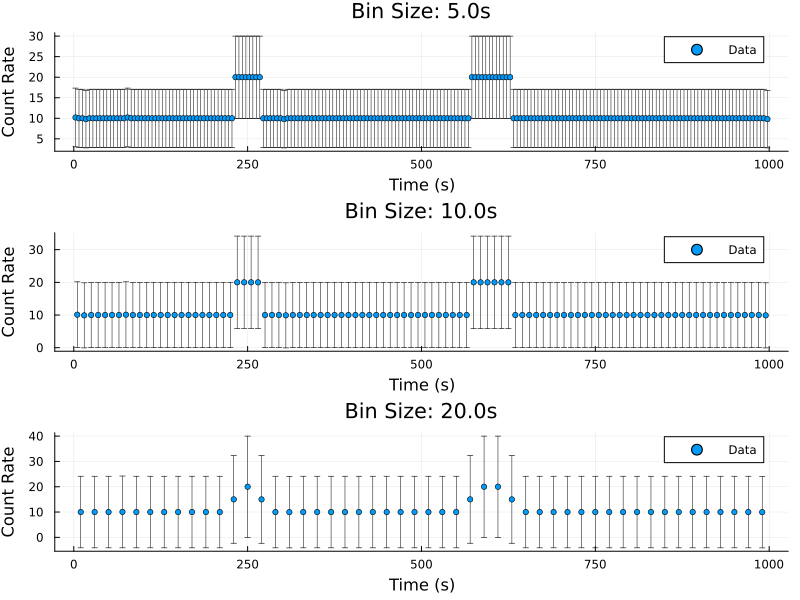


Comparing error calculation methods...


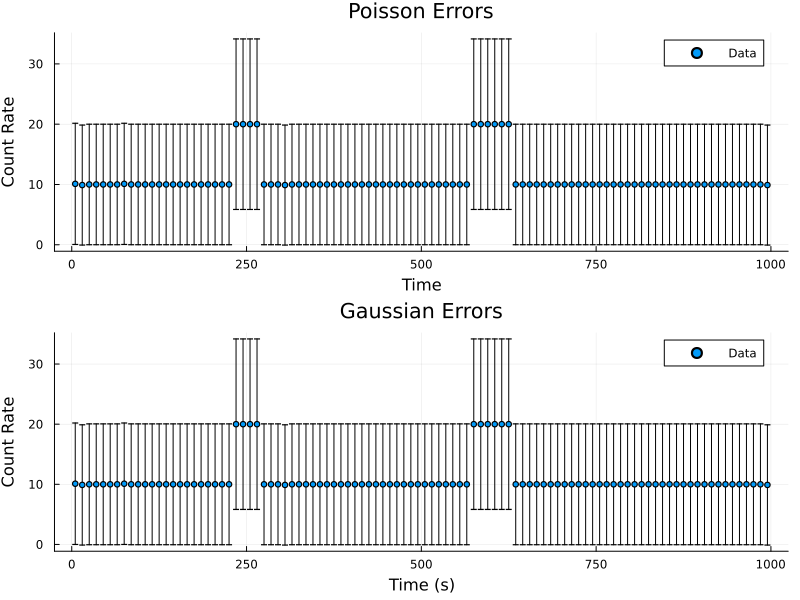


Comparing original and rebinned light curves...


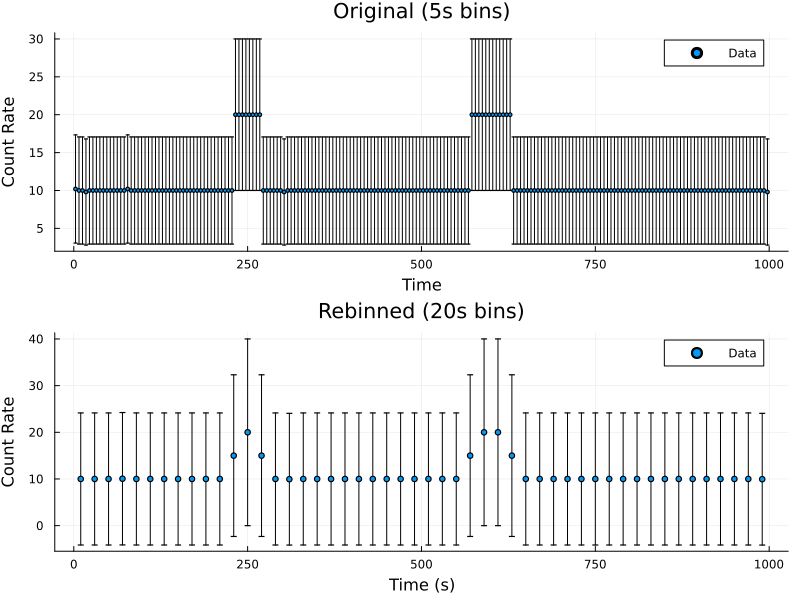


Showing different visualization styles...


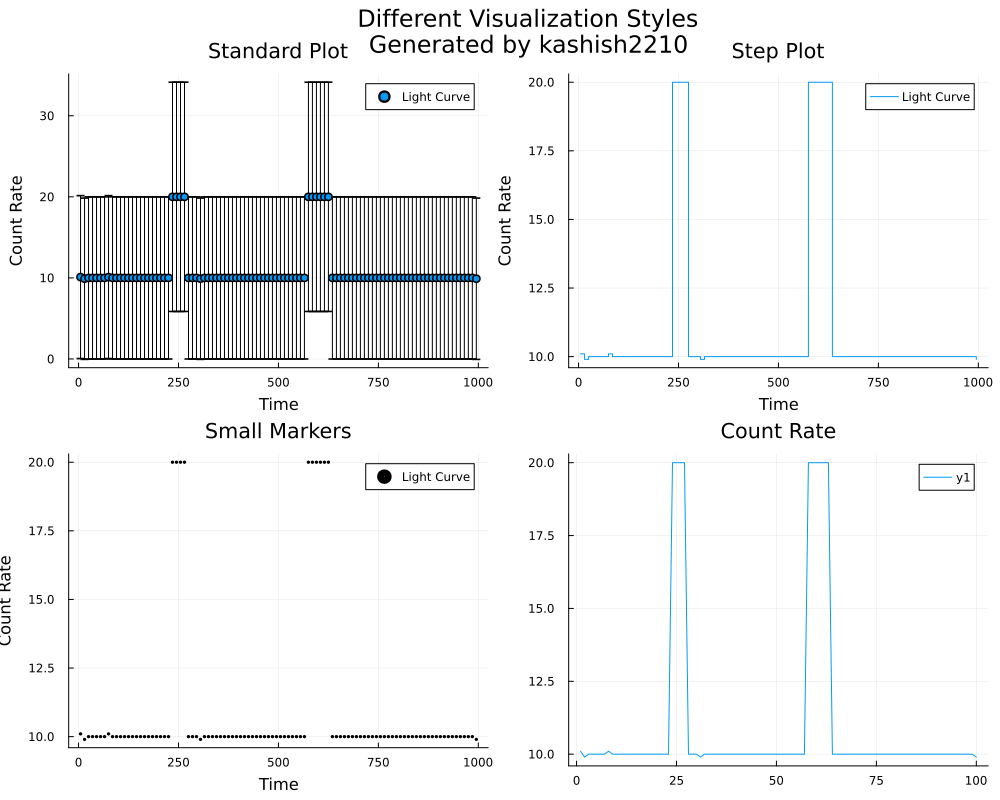

In [9]:
using Plots
using Random
using Dates
using Statistics
using FITSIO

# Set current date and user info
const CURRENT_DATE = DateTime("2025-05-12T20:12:21")
const CURRENT_USER = "kashish2210"

# Set random seed for reproducibility
Random.seed!(20250512)

"""
Generate a simulated light curve with artificial bursts
"""
function generate_test_data(;
    n_events=10000,
    time_range=(0.0, 1000.0),
    base_rate=50.0,
    burst_times=[250.0, 600.0],
    burst_amplitudes=[200.0, 150.0],
    burst_widths=[20.0, 30.0]
)
    times = Float64[]
    t = time_range[1]
    
    while t < time_range[2]
        if rand() < (base_rate * 0.1)
            # Add bursts
            for (bt, ba, bw) in zip(burst_times, burst_amplitudes, burst_widths)
                if abs(t - bt) < bw
                    if rand() < (ba * exp(-(t - bt)^2/(2*bw^2)) * 0.1)
                        push!(times, t)
                    end
                end
            end
            push!(times, t)
        end
        t += 0.1
    end
    
    sort!(times)
    energies = rand(length(times)) .* 10.0 .+ 0.1
    
    headers = [Dict{String,Any}(
        "TELESCOP" => "SIMULATOR",
        "INSTRUME" => "TEST",
        "DATE-OBS" => string(CURRENT_DATE),
        "OBJECT" => "Test Source",
        "EXPOSURE" => time_range[2] - time_range[1]
    )]
    
    EventList{Float64}("simulated.fits", times, energies, DictMetadata(headers))
end

# Generate test data
println("Simulated data generated by $CURRENT_USER at $CURRENT_DATE")
events = generate_test_data()

# 1. Plot light curves with different bin sizes
println("\nPlotting light curves with different bin sizes...")
binsizes = [5.0, 10.0, 20.0]
plots_binsize = []

for binsize in binsizes
    lc = create_lightcurve(events, binsize)
    p = plot(lc, 
            with_errors=true,
            title="Bin Size: $(binsize)s",
            ylabel="Count Rate",
            xlabel="Time (s)",
            label="Data",
            markersize=3,
            markerstrokewidth=0.5)
    push!(plots_binsize, p)
end

display(plot(plots_binsize..., 
       layout=(length(binsizes), 1), 
       size=(800, 200*length(binsizes)),
       link=:x))

# 2. Compare error methods
println("\nComparing error calculation methods...")
lc_poisson = create_lightcurve(events, 10.0, err_method=:poisson)
lc_gauss = create_lightcurve(events, 10.0, err_method=:gaussian)

p_errors = plot(
    plot(lc_poisson, 
         title="Poisson Errors",
         ylabel="Count Rate",
         label="Data",
         markersize=3),
    plot(lc_gauss,
         title="Gaussian Errors",
         ylabel="Count Rate",
         xlabel="Time (s)",
         label="Data",
         markersize=3),
    layout=(2,1), 
    size=(800, 600), 
    link=:x
)
display(p_errors)

# 3. Original vs Rebinned comparison
println("\nComparing original and rebinned light curves...")
lc_original = create_lightcurve(events, 5.0)
lc_rebinned = rebin(lc_original, 20.0)

p_rebin = plot(
    plot(lc_original,
         title="Original (5s bins)",
         ylabel="Count Rate",
         label="Data",
         markersize=2),
    plot(lc_rebinned,
         title="Rebinned (20s bins)",
         ylabel="Count Rate",
         xlabel="Time (s)",
         label="Data",
         markersize=3),
    layout=(2,1), 
    size=(800, 600), 
    link=:x
)
display(p_rebin)

# 4. Different visualization styles
println("\nShowing different visualization styles...")
lc = create_lightcurve(events, 10.0)

p_styles = plot(
    plot(lc, title="Standard Plot"),
    plot(lc, with_errors=false, seriestype=:step, title="Step Plot"),
    plot(lc, markersize=1, with_errors=false, title="Small Markers"),
    plot(countrate(lc), title="Count Rate"),
    layout=(2,2),
    size=(1000, 800),
    plot_title="Different Visualization Styles\nGenerated by $CURRENT_USER"
)
display(p_styles)

In [12]:
using Test
using FITSIO

@testset "LightCurve Tests" begin
    # Test 1: Create a lightcurve from a sample EventList
    @testset "Lightcurve creation" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])  # Empty primary array
        
        # Create a binary table HDU with TIME and ENERGY columns
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        # Add a binary table extension
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        
        @test isfile(sample_file)
        
        # Test reading the sample file
        data = readevents(sample_file)
        @test data.filename == sample_file
        @test length(data.times) == 5
        @test length(data.energies) == 5
        @test eltype(data.times) == Float64
        @test eltype(data.energies) == Float64
        
        # Create a lightcurve from the event data
        lc = create_lightcurve(data, 1.0)
        
        # Basic size checks
        @test length(lc.timebins) == 5
        @test length(lc.counts) == 5
        
        # Time bin checks - bins should be centered
        @test lc.timebins[1] ≈ 1.5
        @test lc.timebins[end] ≈ 5.5
        
        # Count checks
        expected_counts = [1, 1, 1, 1, 0]  # Last bin is empty due to binning
        @test all(lc.counts .== expected_counts)
        
        # Error checks
        expected_errors = sqrt.(Float64.(expected_counts))
        @test all(lc.count_error .≈ expected_errors)
        
        # Method check
        @test lc.err_method == :poisson
    end

    # Test 2: Test lightcurve with different bin sizes
    @testset "Different bin sizes" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_bin_sizes.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        # Create data
        times = Float64[1.0, 2.0, 3.0, 3.5, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 30.0, 25.0, 15.0, 10.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        data = readevents(sample_file)
    
        # Test with bin size of 2.0
        lc_2 = create_lightcurve(data, 2.0)
        @test length(lc_2.timebins) == 3
        @test length(lc_2.counts) == 3
        @test lc_2.timebins[1] ≈ 2.0
        @test lc_2.timebins[end] ≈ 6.0
        @test lc_2.counts == [2, 3, 0]  # Last bin empty
        @test lc_2.count_error ≈ sqrt.([2.0, 3.0, 0.0])
    
        # Test with bin size of 1.0
        lc_1 = create_lightcurve(data, 1.0)
        @test length(lc_1.timebins) == 5
        @test length(lc_1.counts) == 5
        @test lc_1.timebins[1] ≈ 1.5
        @test lc_1.timebins[end] ≈ 5.5
        @test lc_1.counts == [1, 1, 2, 1, 0]  # Last bin empty
        @test lc_1.count_error ≈ sqrt.([1.0, 1.0, 2.0, 1.0, 0.0])
    end
    
    # Test 3: Test lightcurve error computation methods
    @testset "Error computation methods" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_error_methods.fits")
        f = FITS(sample_file, "w")
        write(f, Int[])
        # Create data
        times = Float64[1.0, 2.0, 2.5, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 20.0, 25.0, 15.0, 10.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)
        data = readevents(sample_file)
    
        # Test with default error method (Poisson)
        lc = create_lightcurve(data, 1.0)
        expected_counts = [1, 2, 1, 1, 0]  # Last bin empty
        @test lc.count_error ≈ sqrt.(Float64.(expected_counts))
        
        # Test invalid error method
        @test_throws ArgumentError create_lightcurve(data, 1.0, err_method=:invalid)
    end

    @testset "LightCurve Struct Type Checks" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "sample_types.fits")
        
        f = FITS(sample_file, "w")
        write(f, Int[])
        
        times = Float64[1.0, 2.0, 3.0, 4.0, 5.0]
        energies = Float64[10.0, 20.0, 15.0, 25.0, 30.0]
        
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        @testset "Type Parametric Struct Tests" begin
            # Test Float64 EventList
            data_f64 = readevents(sample_file, T=Float64)
            @test isa(data_f64, EventList{Float64})
            @test typeof(data_f64) == EventList{Float64}
            
            lc_f64 = create_lightcurve(data_f64, 1.0)
            @test isa(lc_f64, LightCurve{Float64})
            @test typeof(lc_f64) == LightCurve{Float64}

            # Test Float32 EventList
            data_f32 = readevents(sample_file, T=Float32)
            @test isa(data_f32, EventList{Float32})
            @test typeof(data_f32) == EventList{Float32}

            lc_f32 = create_lightcurve(data_f32, 1.0)
            @test isa(lc_f32, LightCurve{Float32})
            @test typeof(lc_f32) == LightCurve{Float32}
        end

        @testset "Struct Field Type Checks" begin
            data = readevents(sample_file)
            
            @test isa(data.filename, String)
            @test isa(data.times, Vector{Float64})
            @test isa(data.energies, Vector{Float64})
            @test isa(data.metadata, DictMetadata)
            @test isa(data.metadata.headers, Vector{Dict{String,Any}})

            lc = create_lightcurve(data, 1.0)
            @test isa(lc.timebins, Vector{Float64})
            @test isa(lc.counts, Vector{Int})
            @test isa(lc.count_error, Vector{Float64})
            @test isa(lc.err_method, Symbol)
        end
    end

    @testset "Edge Cases" begin
        test_dir = mktempdir()
        sample_file = joinpath(test_dir, "edge_cases.fits")
        
        # Test single event
        f = FITS(sample_file, "w")
        write(f, Int[])
        times = Float64[1.0]
        energies = Float64[10.0]
        table = Dict{String,Array}()
        table["TIME"] = times
        table["ENERGY"] = energies
        write(f, table)
        close(f)

        data = readevents(sample_file)
        lc = create_lightcurve(data, 1.0)
        @test length(lc.counts) == 1
        @test lc.counts[1] == 0  # Event at edge of bin
        @test lc.count_error[1] ≈ 0.0

        # Test empty event list
        f = FITS(sample_file, "w")
        write(f, Int[])
        table = Dict{String,Array}()
        table["TIME"] = Float64[]
        table["ENERGY"] = Float64[]
        write(f, table)
        close(f)

        empty_data = readevents(sample_file)
        @test_throws ArgumentError create_lightcurve(empty_data, 1.0)
    end
end

Test Summary:    | Pass  Total  Time
LightCurve Tests |   48     48  0.3s


[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_dEg1Ec\sample.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_w6en5u\sample_bin_sizes.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_P0zFRz\sample_error_methods.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_rjer31\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_rjer31\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_rjer31\sample_types.fits
[ Info: Found complete event data in extension 2 of C:\Users\asus4\AppData\Local\Temp\jl_6ZvqBR\edge_cases.fits
┌ Warning: No TIME data found in FITS file C:\Users\asus4\AppData\Local\Temp\jl_6ZvqBR\edge_cases.fits. Time series analysis will not be possible.
└ @ Main In[2]:99
┌ Warning: No ENERGY data found i

Test.DefaultTestSet("LightCurve Tests", Any[Test.DefaultTestSet("Lightcurve creation", Any[], 13, false, false, true, 1.747081277751e9, 1.747081277967e9, false, "In[12]"), Test.DefaultTestSet("Different bin sizes", Any[], 12, false, false, true, 1.747081277967e9, 1.74708127799e9, false, "In[12]"), Test.DefaultTestSet("Error computation methods", Any[], 2, false, false, true, 1.74708127799e9, 1.747081278003e9, false, "In[12]"), Test.DefaultTestSet("LightCurve Struct Type Checks", Any[Test.DefaultTestSet("Type Parametric Struct Tests", Any[], 8, false, false, true, 1.747081278003e9, 1.747081278034e9, false, "In[12]"), Test.DefaultTestSet("Struct Field Type Checks", Any[], 9, false, false, true, 1.747081278034e9, 1.747081278035e9, false, "In[12]")], 0, false, false, true, 1.747081278003e9, 1.747081278035e9, false, "In[12]"), Test.DefaultTestSet("Edge Cases", Any[], 4, false, false, true, 1.747081278035e9, 1.747081278051e9, false, "In[12]")], 0, false, false, true, 1.747081277751e9, 1.7470